# 1. pyhf and cabinetry

In [1]:
import glob
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm import tqdm
import pyhf
import cabinetry
cabinetry.set_logging()
import json
import yaml
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
#pyhf.set_backend('numpy','minuit')

In [2]:
# load workspace to cabinetry
workspace_file = '/home/belle/zhangboy/R_D/Signal_MC14ri/2d_2channels_workspace_3_1.json'
results = 'results_3.yaml'

ws = cabinetry.workspace.load(workspace_file)
model, fake_data = cabinetry.model_utils.model_and_data(ws)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier n3 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier n1 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier n4 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier n2 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier n6 (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier n5 (1 new nuisance parameters)


In [3]:
model_prefit = cabinetry.model_utils.prediction(model)

DEBUG - cabinetry.model_utils - total stdev is [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
DEBUG - cabinetry.model_utils - total stdev per channel is [0]


In [12]:
# split the sample to 10 pieces and fit each one
Dstst_e_nu_selection = 'DecayMode=="all_Dstst_e_nu" and D_mcPDG*e_mcPDG==411*11 and e_genMotherPDG==B0_mcPDG and \
    ((B0_mcErrors<64 and B0_mcPDG*D_mcPDG==-511*411) or (B0_mcErrors<512 and abs(B0_mcPDG)==521))'
Dstst_tau_nu_selection = 'DecayMode=="all_Dstst_tau_nu" and D_mcPDG*e_mcPDG==411*11 and e_mcPDG*e_genMotherPDG==11*15 and \
    ((B0_mcErrors<64 and B0_mcPDG*D_mcPDG==-511*411) or (B0_mcErrors<512 and abs(B0_mcPDG)==521))'
signals_selection = 'B0_mcPDG*D_mcPDG==-511*411 and D_mcPDG*e_mcPDG==411*11 and e_mcPDG*e_genMotherPDG==11*15'
norms_selection = 'B0_mcPDG*D_mcPDG==-511*411 and D_mcPDG*e_mcPDG==411*11 and e_genMotherPDG==B0_mcPDG'

folder = '/home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1'
pfs = glob.glob(f"{folder}/sub0?_?.parquet")
chunkNum = 0

for file_path in tqdm(pfs, desc ="Looping over chunks"):
    samples = {}

    df_bestSelected = pandas.read_parquet(file_path, engine="pyarrow")

    # Signal components
    sig_D_tau_nu=df_bestSelected.query(f'DecayMode=="sig_D_tau_nu" and B0_mcErrors<32 and {signals_selection}').copy()
    sig_Dst_tau_nu=df_bestSelected.query(f'DecayMode=="sig_Dst_tau_nu" and B0_mcErrors<64 and {signals_selection}').copy()
    sig_D_e_nu=df_bestSelected.query(f'DecayMode=="sig_D_e_nu" and B0_mcErrors<16 and {norms_selection}').copy()
    sig_Dst_e_nu=df_bestSelected.query(f'DecayMode=="sig_Dst_e_nu" and B0_mcErrors<64 and {norms_selection}').copy() 
    all_Dstst_tau_nu=df_bestSelected.query(Dstst_tau_nu_selection).copy() 
    all_Dstst_e_nu=df_bestSelected.query(Dstst_e_nu_selection).copy()

    samples['$D\\tau\\nu$'] = sig_D_tau_nu
    samples['$D^\\ast\\tau\\nu$'] = sig_Dst_tau_nu
    samples['$D\ell\\nu$'] = sig_D_e_nu
    samples['$D^\\ast\ell\\nu$'] = sig_Dst_e_nu
    samples['$D^{\\ast\\ast}\\tau\\nu$'] = all_Dstst_tau_nu
    samples['$D^{\\ast\\ast}\ell\\nu$'] = all_Dstst_e_nu
    
    print(f'file: {file_path}')
    for name in samples:
          print(f'{name}: {len(samples[name])}')

        #sig_D_mu_nu=df_bestSelected.query('DecayMode=="sig_D_mu_nu" and B0_mcErrors<16').copy()
        #sig_Dst_mu_nu=df_bestSelected.query('DecayMode=="sig_Dst_mu_nu" and (16<=B0_mcErrors<32 or B0_mcErrors<8)').copy()
        #all_Dstst_mu_nu=df_bestSelected.query('DecayMode=="all_Dstst_mu_nu" and (16<=B0_mcErrors<64 or B0_mcErrors<8)').copy()

        # Bkg components
    #     bkg_fakeD = df_bestSelected.query('abs(D_mcPDG)!=411 and B0_mcErrors!=512 and B0_isContinuumEvent!=1').copy()
    #     bkg_fakeTracksClusters = df_bestSelected.query('B0_mcErrors==512 and B0_isContinuumEvent!=1').copy()
    #     bkg_fakeDTC = pandas.concat([bkg_fakeD, bkg_fakeTracksClusters])

    #     bkg_combinatorial = df_bestSelected.query('B0_mcPDG==300553 and abs(D_mcPDG)==411 and B0_mcErrors!=512 and B0_isContinuumEvent!=1').copy()
    #     bkg_sigOtherBDTaudecay = df_bestSelected.query('(DecayMode=="bkg" or DecayMode=="sig_D_mu_nu" or DecayMode=="sig_Dst_mu_nu" or DecayMode=="all_Dstst_mu_nu") and \
    #     B0_mcPDG!=300553 and abs(D_mcPDG)==411 and B0_mcErrors!=512 and B0_isContinuumEvent!=1').copy()
    #     bkg_fakeB = pandas.concat([bkg_combinatorial, bkg_sigOtherBDTaudecay])

    #     bkg_continuum = df_bestSelected.query('B0_isContinuumEvent==1').copy()

    #     bkg_others = pandas.concat([df_bestSelected,
    #                                sig_D_e_nu,
    #                                sig_D_tau_nu,
    #                                sig_Dst_e_nu,
    #                                sig_Dst_tau_nu,
    #                                all_Dstst_e_nu,
    #                                all_Dstst_tau_nu,
    #                                bkg_fakeDTC,
    #                                bkg_fakeB,
    #                                bkg_continuum]).drop_duplicates(keep=False)
        # Weird! the bkg_others contains some events with
        # correct sig decay hash chain and correct B0_mcPDG, D_mcPDG, e_genMotherPDG,
        # but with 128< B0_mcErrors < 256 (misID)

    #     components = {'sig_D_l_nu':sig_D_e_nu,
    #                  'sig_D_tau_nu':sig_D_tau_nu,
    #                  'sig_Dst_l_nu':sig_Dst_e_nu,
    #                  'sig_Dst_tau_nu':sig_Dst_tau_nu,
    #                  'all_Dstst_l_nu':all_Dstst_e_nu,
    #                  'all_Dstst_tau_nu':all_Dstst_tau_nu,
    #                  'bkg_fakeDTC':bkg_fakeDTC,
    #                  'bkg_fakeB':bkg_fakeB,
    #                  'bkg_continuum':bkg_continuum,
    #                  'bkg_others':bkg_others}

    #     samples[decaymode] = components



    sample_list = []
    for name in samples:
        sample_list.append(samples[name].reset_index(drop=True))
    df_merged = pandas.concat(sample_list)

    
    cut='B0_roeMbc_my_mask>4.26'
    xedges = np.linspace(-2, 10, 48) # -7.5 for weMiss2, -2 for weMiss3, -2.5 for weMiss4
    yedges = np.linspace(0.4, 4.6, 42)
    variable_x = 'B0_CMS3_weMissM2'
    variable_y = 'p_D_l'

    (counts, xedges, yedges) = np.histogram2d(df_merged.query(cut)[variable_x], 
                                              df_merged.query(cut)[variable_y],
                                              bins=[xedges, yedges])
    counts = counts.T
    
    
    
    
    fix_parameters = model.config.suggested_fixed()
    print(f'{model.config.samples=}')
    print(f'{model.config.par_order=}')

    # if fit only one component
    #fix_parameters[:] = [False if i=='$D^{\\ast\\ast}\\ell\\nu$' else True for i in model.config.samples]# only allow one parameter to float

    print(f'{fix_parameters=}')
    # data = np.concatenate([counts.flat]) or counts.ravel().tolist()
    data = counts.ravel().tolist()
    fit_results = cabinetry.fit.fit(model, data, goodness_of_fit=True,
                                    fix_pars=fix_parameters, custom_fit=False, maxiter=1000000)

    template_counts = [np.array(model.nominal_rates[0][i][0] - 0.0001).sum() for i in range(model.config.npars)]
    # fitted_counts = template_counts x normalization
    fitted_counts = [round(fit_results.bestfit[i] * template_counts[i]) for i in range(model.config.npars)]
    # fitted_counts_err = template_counts_err, normalization_err in quadrature error
    #                   = fitted_counts x sqrt( (1/template_count) + (norm_err/norm)**2 )
    #                   = fitted_counts x sqrt( (1/template_count) ) if norm ==0
    fitted_counts_error = [round(fitted_counts[i] * np.sqrt(1/template_counts[i])) if fit_results.bestfit[i]==0 else round(fitted_counts[i] * np.sqrt(1/template_counts[i] + (fit_results.uncertainty[i]/fit_results.bestfit[i])**2)) for i in range(model.config.npars)]

    for i in range(model.config.npars):
        component_name = model.config.samples[i]
        print(f'{component_name=}')
        print(f'{fitted_counts[i]} ± {fitted_counts_error[i]}\n')
        
        with open(results, 'r+') as f:
            data = yaml.safe_load(f)
            data['signal_e'][component_name]['difference'][chunkNum]=fitted_counts[i] - len(samples[component_name])
            data['signal_e'][component_name]['errors'][chunkNum]=fitted_counts_error[i]
            f.seek(0)        # <--- should reset file position to the beginning.
            yaml.dump(data, f, indent=4)
            f.truncate()     # remove remaining part
    
    sum_event = round(model.expected_data(fit_results.bestfit).sum())
    print(f'\n{sum_event=}')
    print(f'Total fitted counts uncertainty: ')
    print(f'Total generated counts: {len(df_merged)}')
    #print(f'\n{fit_results=}')
    
    with open(results, 'r+') as f:
        data = yaml.safe_load(f)
        data['signal_e']['sum']['difference'][chunkNum]=sum_event - len(df_merged)
        f.seek(0)        # <--- should reset file position to the beginning.
        yaml.dump(data, f, indent=4)
        f.truncate()     # remove remaining part

    chunkNum += 1

Looping over chunks:   0%|                               | 0/12 [00:00<?, ?it/s]

file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub04_0.parquet
$D\tau\nu$: 1568
$D^\ast\tau\nu$: 985
$D\ell\nu$: 37867
$D^\ast\ell\nu$: 29036
$D^{\ast\ast}\tau\nu$: 1163
$D^{\ast\ast}\ell\nu$: 30104


INFO - cabinetry.fit - performing maximum likelihood fit


model.config.samples=['$D\\ell\\nu$', '$D\\tau\\nu$', '$D^\\ast\\ell\\nu$', '$D^\\ast\\tau\\nu$', '$D^{\\ast\\ast}\\ell\\nu$', '$D^{\\ast\\ast}\\tau\\nu$']
model.config.par_order=['n3', 'n1', 'n4', 'n2', 'n6', 'n5']
fix_parameters=[False, False, False, False, False, False]


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4348                       │              Nfcn = 697              │
│ EDM = 3.02e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 4348.004234 at

component_name='$D\\ell\\nu$'
38189 ± 346

component_name='$D\\tau\\nu$'
2385 ± 510

component_name='$D^\\ast\\ell\\nu$'
28999 ± 448

component_name='$D^\\ast\\tau\\nu$'
0 ± 0

component_name='$D^{\\ast\\ast}\\ell\\nu$'
29367 ± 549

component_name='$D^{\\ast\\ast}\\tau\\nu$'
1750 ± 313


sum_event=100690
Total fitted counts uncertainty: 
Total generated counts: 100723
file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub03_0.parquet
$D\tau\nu$: 1534
$D^\ast\tau\nu$: 945
$D\ell\nu$: 38368
$D^\ast\ell\nu$: 29106
$D^{\ast\ast}\tau\nu$: 1107
$D^{\ast\ast}\ell\nu$: 30109


INFO - cabinetry.fit - performing maximum likelihood fit


model.config.samples=['$D\\ell\\nu$', '$D\\tau\\nu$', '$D^\\ast\\ell\\nu$', '$D^\\ast\\tau\\nu$', '$D^{\\ast\\ast}\\ell\\nu$', '$D^{\\ast\\ast}\\tau\\nu$']
model.config.par_order=['n3', 'n1', 'n4', 'n2', 'n6', 'n5']
fix_parameters=[False, False, False, False, False, False]


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4488                       │              Nfcn = 691              │
│ EDM = 1.98e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 4487.642790 at

component_name='$D\\ell\\nu$'
38730 ± 348

component_name='$D\\tau\\nu$'
1586 ± 508

component_name='$D^\\ast\\ell\\nu$'
29062 ± 450

component_name='$D^\\ast\\tau\\nu$'
665 ± 520

component_name='$D^{\\ast\\ast}\\ell\\nu$'
29598 ± 543

component_name='$D^{\\ast\\ast}\\tau\\nu$'
1512 ± 374


sum_event=101153
Total fitted counts uncertainty: 
Total generated counts: 101169
file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub01_1.parquet
$D\tau\nu$: 1677
$D^\ast\tau\nu$: 1022
$D\ell\nu$: 41941
$D^\ast\ell\nu$: 32051
$D^{\ast\ast}\tau\nu$: 1160
$D^{\ast\ast}\ell\nu$: 31487


INFO - cabinetry.fit - performing maximum likelihood fit


model.config.samples=['$D\\ell\\nu$', '$D\\tau\\nu$', '$D^\\ast\\ell\\nu$', '$D^\\ast\\tau\\nu$', '$D^{\\ast\\ast}\\ell\\nu$', '$D^{\\ast\\ast}\\tau\\nu$']
model.config.par_order=['n3', 'n1', 'n4', 'n2', 'n6', 'n5']
fix_parameters=[False, False, False, False, False, False]


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4607                       │              Nfcn = 584              │
│ EDM = 1.5e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 4607.111229 at

component_name='$D\\ell\\nu$'
42043 ± 365

component_name='$D\\tau\\nu$'
1400 ± 636

component_name='$D^\\ast\\ell\\nu$'
32813 ± 473

component_name='$D^\\ast\\tau\\nu$'
2594 ± 727

component_name='$D^{\\ast\\ast}\\ell\\nu$'
29829 ± 576

component_name='$D^{\\ast\\ast}\\tau\\nu$'
626 ± 431



Looping over chunks:  25%|█████▊                 | 3/12 [00:08<00:26,  2.97s/it]


sum_event=109305
Total fitted counts uncertainty: 
Total generated counts: 109338
file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub00_0.parquet
$D\tau\nu$: 1920
$D^\ast\tau\nu$: 1202
$D\ell\nu$: 48279
$D^\ast\ell\nu$: 36635
$D^{\ast\ast}\tau\nu$: 943
$D^{\ast\ast}\ell\nu$: 27062


INFO - cabinetry.fit - performing maximum likelihood fit


model.config.samples=['$D\\ell\\nu$', '$D\\tau\\nu$', '$D^\\ast\\ell\\nu$', '$D^\\ast\\tau\\nu$', '$D^{\\ast\\ast}\\ell\\nu$', '$D^{\\ast\\ast}\\tau\\nu$']
model.config.par_order=['n3', 'n1', 'n4', 'n2', 'n6', 'n5']
fix_parameters=[False, False, False, False, False, False]
W MnPosDef Matrix forced pos-def by adding to diagonal 0.592485
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.0911749 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 3 ] = -0.0039258
W MnPosDef non-positive diagonal element in covariance matrix[ 5 ] = -1.51941e-06
W MnPosDef Added to diagonal of Error matrix a value 0.503927
W VariableMetricBuilder gdel = -470.214
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def., try to make pos.def.
W MnPosDef Matrix forced pos-def by adding to diagonal 0.790139


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4566                       │              Nfcn = 985              │
│ EDM = 5.38e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 4565.918732 at

component_name='$D\\ell\\nu$'
47995 ± 391

component_name='$D\\tau\\nu$'
3066 ± 640

component_name='$D^\\ast\\ell\\nu$'
37248 ± 491

component_name='$D^\\ast\\tau\\nu$'
656 ± 884

component_name='$D^{\\ast\\ast}\\ell\\nu$'
25684 ± 563

component_name='$D^{\\ast\\ast}\\tau\\nu$'
1362 ± 535


sum_event=116011
Total fitted counts uncertainty: 
Total generated counts: 116041
file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub03_1.parquet
$D\tau\nu$: 1446
$D^\ast\tau\nu$: 984
$D\ell\nu$: 38184
$D^\ast\ell\nu$: 29040
$D^{\ast\ast}\tau\nu$: 1123
$D^{\ast\ast}\ell\nu$: 30140


INFO - cabinetry.fit - performing maximum likelihood fit


model.config.samples=['$D\\ell\\nu$', '$D\\tau\\nu$', '$D^\\ast\\ell\\nu$', '$D^\\ast\\tau\\nu$', '$D^{\\ast\\ast}\\ell\\nu$', '$D^{\\ast\\ast}\\tau\\nu$']
model.config.par_order=['n3', 'n1', 'n4', 'n2', 'n6', 'n5']
fix_parameters=[False, False, False, False, False, False]
W MnPosDef Matrix forced pos-def by adding to diagonal 2.71707
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.00238247 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 3 ] = -1.93395e-06
W MnPosDef non-positive diagonal element in covariance matrix[ 5 ] = -0.0119901
W MnPosDef Added to diagonal of Error matrix a value 0.511991
W VariableMetricBuilder gdel = -14.8734
W VariableMetricBuilder No improvement in line search
W MnPosDef Matrix forced pos-def by adding to diagonal 1.29248


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4587                       │             Nfcn = 1115              │
│ EDM = 0.000106 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 4586.750239 at

component_name='$D\\ell\\nu$'
38389 ± 347

component_name='$D\\tau\\nu$'
2691 ± 602

component_name='$D^\\ast\\ell\\nu$'
29512 ± 454

component_name='$D^\\ast\\tau\\nu$'
1893 ± 918

component_name='$D^{\\ast\\ast}\\ell\\nu$'
28322 ± 565

component_name='$D^{\\ast\\ast}\\tau\\nu$'
83 ± 1030


sum_event=100890
Total fitted counts uncertainty: 
Total generated counts: 100917
file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub00_1.parquet
$D\tau\nu$: 0
$D^\ast\tau\nu$: 0
$D\ell\nu$: 0
$D^\ast\ell\nu$: 0
$D^{\ast\ast}\tau\nu$: 1451
$D^{\ast\ast}\ell\nu$: 32397


INFO - cabinetry.fit - performing maximum likelihood fit


model.config.samples=['$D\\ell\\nu$', '$D\\tau\\nu$', '$D^\\ast\\ell\\nu$', '$D^\\ast\\tau\\nu$', '$D^{\\ast\\ast}\\ell\\nu$', '$D^{\\ast\\ast}\\tau\\nu$']
model.config.par_order=['n3', 'n1', 'n4', 'n2', 'n6', 'n5']
fix_parameters=[False, False, False, False, False, False]


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3601                       │              Nfcn = 857              │
│ EDM = 1.99e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3600.617690 at

component_name='$D\\ell\\nu$'
225 ± 55

component_name='$D\\tau\\nu$'
406 ± 197

component_name='$D^\\ast\\ell\\nu$'
1433 ± 163

component_name='$D^\\ast\\tau\\nu$'
0 ± 0

component_name='$D^{\\ast\\ast}\\ell\\nu$'
31099 ± 327

component_name='$D^{\\ast\\ast}\\tau\\nu$'
682 ± 116


sum_event=33845
Total fitted counts uncertainty: 
Total generated counts: 33848
file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub05_0.parquet
$D\tau\nu$: 1660
$D^\ast\tau\nu$: 1102
$D\ell\nu$: 42223
$D^\ast\ell\nu$: 32311
$D^{\ast\ast}\tau\nu$: 412
$D^{\ast\ast}\ell\nu$: 15177


INFO - cabinetry.fit - performing maximum likelihood fit


model.config.samples=['$D\\ell\\nu$', '$D\\tau\\nu$', '$D^\\ast\\ell\\nu$', '$D^\\ast\\tau\\nu$', '$D^{\\ast\\ast}\\ell\\nu$', '$D^{\\ast\\ast}\\tau\\nu$']
model.config.par_order=['n3', 'n1', 'n4', 'n2', 'n6', 'n5']
fix_parameters=[False, False, False, False, False, False]


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4255                       │              Nfcn = 846              │
│ EDM = 1.24e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 4255.117051 at

component_name='$D\\ell\\nu$'
41769 ± 357

component_name='$D\\tau\\nu$'
1949 ± 513

component_name='$D^\\ast\\ell\\nu$'
32644 ± 436

component_name='$D^\\ast\\tau\\nu$'
1415 ± 495

component_name='$D^{\\ast\\ast}\\ell\\nu$'
14383 ± 462

component_name='$D^{\\ast\\ast}\\tau\\nu$'
691 ± 279


sum_event=92852
Total fitted counts uncertainty: 
Total generated counts: 92885
file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub01_0.parquet
$D\tau\nu$: 2393
$D^\ast\tau\nu$: 1530
$D\ell\nu$: 62358
$D^\ast\ell\nu$: 47091
$D^{\ast\ast}\tau\nu$: 907
$D^{\ast\ast}\ell\nu$: 29547


INFO - cabinetry.fit - performing maximum likelihood fit


model.config.samples=['$D\\ell\\nu$', '$D\\tau\\nu$', '$D^\\ast\\ell\\nu$', '$D^\\ast\\tau\\nu$', '$D^{\\ast\\ast}\\ell\\nu$', '$D^{\\ast\\ast}\\tau\\nu$']
model.config.par_order=['n3', 'n1', 'n4', 'n2', 'n6', 'n5']
fix_parameters=[False, False, False, False, False, False]


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4697                       │              Nfcn = 645              │
│ EDM = 2.52e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 4696.944719 at

component_name='$D\\ell\\nu$'
61496 ± 450

component_name='$D\\tau\\nu$'
3442 ± 624

component_name='$D^\\ast\\ell\\nu$'
47944 ± 551

component_name='$D^\\ast\\tau\\nu$'
1775 ± 614

component_name='$D^{\\ast\\ast}\\ell\\nu$'
28076 ± 597

component_name='$D^{\\ast\\ast}\\tau\\nu$'
1039 ± 366


sum_event=143772
Total fitted counts uncertainty: 
Total generated counts: 143826
file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub02_0.parquet
$D\tau\nu$: 3282
$D^\ast\tau\nu$: 2059
$D\ell\nu$: 82327
$D^\ast\ell\nu$: 62494
$D^{\ast\ast}\tau\nu$: 741
$D^{\ast\ast}\ell\nu$: 28626


INFO - cabinetry.fit - performing maximum likelihood fit


model.config.samples=['$D\\ell\\nu$', '$D\\tau\\nu$', '$D^\\ast\\ell\\nu$', '$D^\\ast\\tau\\nu$', '$D^{\\ast\\ast}\\ell\\nu$', '$D^{\\ast\\ast}\\tau\\nu$']
model.config.par_order=['n3', 'n1', 'n4', 'n2', 'n6', 'n5']
fix_parameters=[False, False, False, False, False, False]


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5329                       │              Nfcn = 671              │
│ EDM = 2.12e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 5329.262846 at

component_name='$D\\ell\\nu$'
81974 ± 531

component_name='$D\\tau\\nu$'
4106 ± 662

component_name='$D^\\ast\\ell\\nu$'
61891 ± 623

component_name='$D^\\ast\\tau\\nu$'
2849 ± 604

component_name='$D^{\\ast\\ast}\\ell\\nu$'
27623 ± 630

component_name='$D^{\\ast\\ast}\\tau\\nu$'
1038 ± 345


sum_event=179482
Total fitted counts uncertainty: 
Total generated counts: 179529


INFO - cabinetry.fit - performing maximum likelihood fit


file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub05_1.parquet
$D\tau\nu$: 245
$D^\ast\tau\nu$: 145
$D\ell\nu$: 5816
$D^\ast\ell\nu$: 4264
$D^{\ast\ast}\tau\nu$: 807
$D^{\ast\ast}\ell\nu$: 18807
model.config.samples=['$D\\ell\\nu$', '$D\\tau\\nu$', '$D^\\ast\\ell\\nu$', '$D^\\ast\\tau\\nu$', '$D^{\\ast\\ast}\\ell\\nu$', '$D^{\\ast\\ast}\\tau\\nu$']
model.config.par_order=['n3', 'n1', 'n4', 'n2', 'n6', 'n5']
fix_parameters=[False, False, False, False, False, False]


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3525                       │              Nfcn = 939              │
│ EDM = 0.000176 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 3524.874144 at

component_name='$D\\ell\\nu$'
5906 ± 140

component_name='$D\\tau\\nu$'
606 ± 283

component_name='$D^\\ast\\ell\\nu$'
4837 ± 220

component_name='$D^\\ast\\tau\\nu$'
0 ± 0

component_name='$D^{\\ast\\ast}\\ell\\nu$'
18152 ± 332

component_name='$D^{\\ast\\ast}\\tau\\nu$'
575 ± 134


sum_event=30075
Total fitted counts uncertainty: 
Total generated counts: 30084
file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub02_1.parquet
$D\tau\nu$: 1737
$D^\ast\tau\nu$: 1163
$D\ell\nu$: 45003
$D^\ast\ell\nu$: 33859
$D^{\ast\ast}\tau\nu$: 1174
$D^{\ast\ast}\ell\nu$: 32658


INFO - cabinetry.fit - performing maximum likelihood fit


model.config.samples=['$D\\ell\\nu$', '$D\\tau\\nu$', '$D^\\ast\\ell\\nu$', '$D^\\ast\\tau\\nu$', '$D^{\\ast\\ast}\\ell\\nu$', '$D^{\\ast\\ast}\\tau\\nu$']
model.config.par_order=['n3', 'n1', 'n4', 'n2', 'n6', 'n5']
fix_parameters=[False, False, False, False, False, False]


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4564                       │              Nfcn = 712              │
│ EDM = 6.75e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 4563.752691 at

component_name='$D\\ell\\nu$'
45322 ± 379

component_name='$D\\tau\\nu$'
2750 ± 603

component_name='$D^\\ast\\ell\\nu$'
33811 ± 483

component_name='$D^\\ast\\tau\\nu$'
1541 ± 554

component_name='$D^{\\ast\\ast}\\ell\\nu$'
31371 ± 583



Looping over chunks:  92%|████████████████████▏ | 11/12 [00:33<00:03,  3.10s/it]

component_name='$D^{\\ast\\ast}\\tau\\nu$'
774 ± 329


sum_event=115570
Total fitted counts uncertainty: 
Total generated counts: 115594
file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub04_1.parquet
$D\tau\nu$: 1513
$D^\ast\tau\nu$: 943
$D\ell\nu$: 38789
$D^\ast\ell\nu$: 29370
$D^{\ast\ast}\tau\nu$: 1097
$D^{\ast\ast}\ell\nu$: 30115


INFO - cabinetry.fit - performing maximum likelihood fit


model.config.samples=['$D\\ell\\nu$', '$D\\tau\\nu$', '$D^\\ast\\ell\\nu$', '$D^\\ast\\tau\\nu$', '$D^{\\ast\\ast}\\ell\\nu$', '$D^{\\ast\\ast}\\tau\\nu$']
model.config.par_order=['n3', 'n1', 'n4', 'n2', 'n6', 'n5']
fix_parameters=[False, False, False, False, False, False]


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4586                       │              Nfcn = 674              │
│ EDM = 1.95e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 4586.002115 at

component_name='$D\\ell\\nu$'
38678 ± 349

component_name='$D\\tau\\nu$'
2061 ± 581

component_name='$D^\\ast\\ell\\nu$'
29959 ± 452

component_name='$D^\\ast\\tau\\nu$'
562 ± 809

component_name='$D^{\\ast\\ast}\\ell\\nu$'
29156 ± 547

component_name='$D^{\\ast\\ast}\\tau\\nu$'
1386 ± 505


sum_event=101803
Total fitted counts uncertainty: 
Total generated counts: 101827


In [5]:
# fit the whole sample
Dstst_e_nu_selection = 'DecayMode=="all_Dstst_e_nu" and D_mcPDG*e_mcPDG==411*11 and e_genMotherPDG==B0_mcPDG and \
    ((B0_mcErrors<64 and B0_mcPDG*D_mcPDG==-511*411) or (B0_mcErrors<512 and abs(B0_mcPDG)==521))'
Dstst_tau_nu_selection = 'DecayMode=="all_Dstst_tau_nu" and D_mcPDG*e_mcPDG==411*11 and e_mcPDG*e_genMotherPDG==11*15 and \
    ((B0_mcErrors<64 and B0_mcPDG*D_mcPDG==-511*411) or (B0_mcErrors<512 and abs(B0_mcPDG)==521))'
signals_selection = 'B0_mcPDG*D_mcPDG==-511*411 and D_mcPDG*e_mcPDG==411*11 and e_mcPDG*e_genMotherPDG==11*15'
norms_selection = 'B0_mcPDG*D_mcPDG==-511*411 and D_mcPDG*e_mcPDG==411*11 and e_genMotherPDG==B0_mcPDG'

folder = '/home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1'
pfs = glob.glob(f"{folder}/sub0?_?.parquet")
chunkNum = 0
samples = []
for file_path in tqdm(pfs, desc ="Looping over chunks"):

    df_bestSelected = pandas.read_parquet(file_path, engine="pyarrow")
    #df2 = pandas.read_feather("../Ntuples/bengal_e_10k_Test2.feather")
    #df_charged = root_pandas.read_root(charged,key='B0')
    #data = pandas.concat([df_mixed,df_charged], ignore_index = True)

    # Signal components
    sig_D_tau_nu=df_bestSelected.query(f'DecayMode=="sig_D_tau_nu" and B0_mcErrors<32 and {signals_selection}').copy()
    sig_Dst_tau_nu=df_bestSelected.query(f'DecayMode=="sig_Dst_tau_nu" and B0_mcErrors<64 and {signals_selection}').copy()
    sig_D_e_nu=df_bestSelected.query(f'DecayMode=="sig_D_e_nu" and B0_mcErrors<16 and {norms_selection}').copy()
    sig_Dst_e_nu=df_bestSelected.query(f'DecayMode=="sig_Dst_e_nu" and B0_mcErrors<64 and {norms_selection}').copy() 
    all_Dstst_tau_nu=df_bestSelected.query(Dstst_tau_nu_selection).copy() 
    all_Dstst_e_nu=df_bestSelected.query(Dstst_e_nu_selection).copy()

    samples.append(sig_D_tau_nu)
    samples.append(sig_Dst_tau_nu)
    samples.append(sig_D_e_nu)
    samples.append(sig_Dst_e_nu)
    samples.append(all_Dstst_tau_nu)
    samples.append(all_Dstst_e_nu)
    
    print(f'file: {file_path}')
    print(f'size: {len(samples[-1])}')

    #     bkg_others = pandas.concat([df_bestSelected,
    #                                sig_D_e_nu,
    #                                sig_D_tau_nu,
    #                                sig_Dst_e_nu,
    #                                sig_Dst_tau_nu,
    #                                all_Dstst_e_nu,
    #                                all_Dstst_tau_nu,
    #                                bkg_fakeDTC,
    #                                bkg_fakeB,
    #                                bkg_continuum]).drop_duplicates(keep=False)
        # Weird! the bkg_others contains some events with
        # correct sig decay hash chain and correct B0_mcPDG, D_mcPDG, e_genMotherPDG,
        # but with 128< B0_mcErrors < 256 (misID)

    #     components = {'sig_D_l_nu':sig_D_e_nu,
    #                  'sig_D_tau_nu':sig_D_tau_nu,
    #                  'sig_Dst_l_nu':sig_Dst_e_nu,
    #                  'sig_Dst_tau_nu':sig_Dst_tau_nu,
    #                  'all_Dstst_l_nu':all_Dstst_e_nu,
    #                  'all_Dstst_tau_nu':all_Dstst_tau_nu,
    #                  'bkg_fakeDTC':bkg_fakeDTC,
    #                  'bkg_fakeB':bkg_fakeB,
    #                  'bkg_continuum':bkg_continuum,
    #                  'bkg_others':bkg_others}

    #     samples[decaymode] = components


df_merged = pandas.concat(samples)


cut='B0_roeMbc_my_mask>4.26'
xedges = np.linspace(-2, 10, 48) # -7.5 for weMiss2, -2 for weMiss3, -2.5 for weMiss4
yedges = np.linspace(0.4, 4.6, 42)
variable_x = 'B0_CMS3_weMissM2'
variable_y = 'p_D_l'

(counts, xedges, yedges) = np.histogram2d(df_merged.query(cut)[variable_x], 
                                          df_merged.query(cut)[variable_y],
                                          bins=[xedges, yedges])
counts = counts.T

Looping over chunks:   8%|█▉                     | 1/12 [00:03<00:42,  3.84s/it]

file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub04_0.parquet
size: 30104


Looping over chunks:  17%|███▊                   | 2/12 [00:06<00:31,  3.13s/it]

file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub03_0.parquet
size: 30109


Looping over chunks:  25%|█████▊                 | 3/12 [00:09<00:26,  2.92s/it]

file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub01_1.parquet
size: 31487


Looping over chunks:  33%|███████▋               | 4/12 [00:11<00:21,  2.72s/it]

file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub00_0.parquet
size: 27062


Looping over chunks:  42%|█████████▌             | 5/12 [00:14<00:18,  2.64s/it]

file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub03_1.parquet
size: 30140


Looping over chunks:  50%|███████████▌           | 6/12 [00:16<00:14,  2.50s/it]

file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub00_1.parquet
size: 32397


Looping over chunks:  58%|█████████████▍         | 7/12 [00:18<00:12,  2.44s/it]

file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub05_0.parquet
size: 15177


Looping over chunks:  67%|███████████████▎       | 8/12 [00:21<00:09,  2.47s/it]

file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub01_0.parquet
size: 29547


Looping over chunks:  75%|█████████████████▎     | 9/12 [00:23<00:07,  2.54s/it]

file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub02_0.parquet
size: 28626


Looping over chunks:  83%|██████████████████▎   | 10/12 [00:25<00:04,  2.30s/it]

file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub05_1.parquet
size: 18807


Looping over chunks:  92%|████████████████████▏ | 11/12 [00:28<00:02,  2.42s/it]

file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub02_1.parquet
size: 32658


Looping over chunks: 100%|██████████████████████| 12/12 [00:30<00:00,  2.53s/it]

file: /home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/sub04_1.parquet
size: 30115


In [6]:
fix_parameters = model.config.suggested_fixed()
print(f'{model.config.samples=}')
print(f'{model.config.par_order=}')

# if fit only one component
#fix_parameters[:] = [False if i=='$D^{\\ast\\ast}\\ell\\nu$' else True for i in model.config.samples]# only allow one parameter to float

print(f'{fix_parameters=}')
# data = np.concatenate([counts.flat]) or counts.ravel().tolist()
data = counts.ravel().tolist()
fit_results = cabinetry.fit.fit(model, data, goodness_of_fit=True,
                                fix_pars=fix_parameters, custom_fit=False)

template_counts = [np.array(model.nominal_rates[0][i][0] - 0.0001).sum() for i in range(model.config.npars)]
# fitted_counts = template_counts x normalization
fitted_counts = [round(fit_results.bestfit[i] * template_counts[i]) for i in range(model.config.npars)]
# fitted_counts_err = template_counts_err, normalization_err in quadrature error
#                   = fitted_counts x sqrt( (1/template_count) + (norm_err/norm)**2 )
#                   = fitted_counts x sqrt( (1/template_count) ) if norm ==0
fitted_counts_error = [round(fitted_counts[i] * np.sqrt(1/template_counts[i])) if fit_results.bestfit[i]==0 else round(fitted_counts[i] * np.sqrt(1/template_counts[i] + (fit_results.uncertainty[i]/fit_results.bestfit[i])**2)) for i in range(model.config.npars)]
   
for i in range(model.config.npars):
    print(model.config.samples[i])
    print(f'{fitted_counts[i]} ± {fitted_counts_error[i]}\n')

print(f'\nTotal_fitted = {round(model.expected_data(fit_results.bestfit).sum())}')
print(f'Total fitted counts uncertainty: ')
print(f'Total generated counts: {len(df_merged)}')
print(f'\n{fit_results=}')

INFO - cabinetry.fit - performing maximum likelihood fit


model.config.samples=['$D\\ell\\nu$', '$D\\tau\\nu$', '$D^\\ast\\ell\\nu$', '$D^\\ast\\tau\\nu$', '$D^{\\ast\\ast}\\ell\\nu$', '$D^{\\ast\\ast}\\tau\\nu$']
model.config.par_order=['n3', 'n1', 'n4', 'n2', 'n6', 'n5']
fix_parameters=[False, False, False, False, False, False]


INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.101e+04                  │              Nfcn = 763              │
│ EDM = 3.1e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 11006.518033 a

$D\ell\nu$
480855 ± 1908

$D\tau\nu$
25236 ± 1916

$D^\ast\ell\nu$
369820 ± 2034

$D^\ast\tau\nu$
15014 ± 2131

$D^{\ast\ast}\ell\nu$
323555 ± 2227

$D^{\ast\ast}\tau\nu$
10964 ± 1337


Total_fitted = 1225447
Total fitted counts uncertainty: 
Total generated counts: 1225781

fit_results=FitResults(bestfit=array([4.83894053, 0.31786695, 4.88211349, 0.30348388, 5.01790791,
       0.07903166]), uncertainty=array([0.01153283, 0.02410132, 0.02015454, 0.04305883, 0.02833133,
       0.00963212]), labels=['n3', 'n1', 'n4', 'n2', 'n6', 'n5'], corr_mat=array([[ 1.00000000e+00, -6.48930827e-02, -6.02010798e-01,
        -2.12730413e-04,  1.65417666e-01,  1.12782446e-02],
       [-6.48930827e-02,  1.00000000e+00,  2.60497984e-01,
        -5.22083914e-01, -6.53068815e-01,  6.10208546e-02],
       [-6.02010798e-01,  2.60497984e-01,  1.00000000e+00,
         4.18186873e-02, -5.69455999e-01, -1.06121872e-01],
       [-2.12730413e-04, -5.22083914e-01,  4.18186873e-02,
         1.00000000e+00, -3.695884

In [32]:
tau_e_BF = 0.17
eff_D_tau_nu = 12194/50000
#eff_D_tau_nu_err = eff_D_tau_nu*np.sqrt(1/12194 + 1/50000)
eff_D_l_nu = 14108/50000
#eff_D_l_nu_err = eff_D_l_nu*np.sqrt(1/14108 + 1/50000)
R_D = fitted_counts[1]/fitted_counts[0]/tau_e_BF * eff_D_l_nu/eff_D_tau_nu
R_D_err = R_D*np.sqrt( (fitted_counts_error[0]/fitted_counts[0])**2 + (fitted_counts_error[1]/fitted_counts[1])**2 + 1/12194 + 1/50000 + 1/14108 + 1/50000)

eff_Dst_tau_nu = 2260/10000
eff_Dst_l_nu = 2466/10000
R_Dst = fitted_counts[3]/fitted_counts[2]/tau_e_BF * eff_Dst_l_nu/eff_Dst_tau_nu
R_Dst_err = R_Dst*np.sqrt( (fitted_counts_error[3]/fitted_counts[3])**2 + (fitted_counts_error[2]/fitted_counts[2])**2 + 1/2260 + 1/10000 + 1/2466 + 1/10000)

print(f'{R_D = :.3f} ± {R_D_err:.3f}')
print(f'{R_Dst = :.3f} ± {R_Dst_err:.3f}')

R_D = 0.357 ± 0.028
R_Dst = 0.261 ± 0.038


In [ ]:
model_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)

In [ ]:
model_postfit.total_stdev_model_channels

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


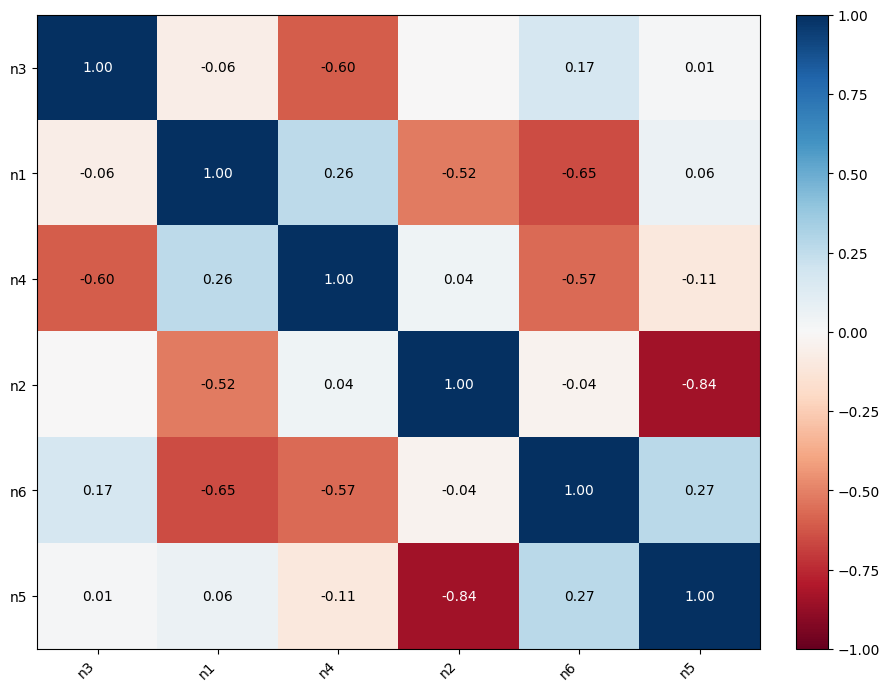

In [107]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.2)

# Plot the fitting results

In [39]:
def statistics(df):
    counts=df.count()
    mean=df.mean()
    std=df.std()
    return f'''counts = %d \nmean = %5.3f \nstd = %5.3f''' %(counts,mean,std)

kwarg={'histtype':'step','lw':2}
    

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

def plot_all_signals(cut, variable):
    fig,axs =plt.subplots(2,3,figsize=(16,10), sharex=True, sharey=False)
    fig.suptitle(f'All signals with {cut}')
    fig.supylabel('# of candidates per bin',x=0.06)
    fig.supxlabel(f'{variable}', y=0.06)
    i=0
    j=0
    for sample_name, sample in samples.items():
        (counts, bins) = np.histogram(sample.query(cut)[variable], bins=50)
        if sample_name in ['sig_D_l_nu','sig_D_tau_nu','bkg_fakeDTC','bkg_fakeB','bkg_continuum','bkg_others']:
            factor = 1
        elif sample_name in ['sig_Dst_l_nu','sig_Dst_tau_nu','all_Dstst_l_nu','all_Dstst_tau_nu']:
            factor = 1
        axs[i,j].hist(bins[:-1], bins, weights=factor*counts,label=sample_name,**kwarg)

        #plt.legend(bbox_to_anchor=(1,1),ncol=3, fancybox=True, shadow=True,labelspacing=1.5)
        axs[i,j].grid()
        axs[i,j].set_title(sample_name)
        j+=1
        if j==3:
            i+=1
            j=0
            
def plot_all_signals_2d(cut):
    variable_x = 'B0_CMS3_weMissM2'
    variable_y = 'p_D_l'
    xedges = np.linspace(-2, 10, 48)
    yedges = np.linspace(0.4, 4.6, 42)

    n_rows,n_cols = [2,3]
    fig,axs=plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,8),sharex=True, sharey='all')
    fig.suptitle('Signals')
    fig.supylabel('$|p_D|\ +\ |p_l|\ [GeV]$', x=0.05)
    fig.supxlabel('$M_{miss}^2\ [GeV^2/c^4]$')
    i=0
    j=0
    for name, sample in samples.items():
        (counts, xedges, yedges) = np.histogram2d(sample.query(cut)[variable_x], 
                                              sample.query(cut)[variable_y],
                                              bins=[xedges, yedges])
        counts = counts.T + 0.01
        X, Y = np.meshgrid(xedges, yedges)
        im=axs[i,j].pcolormesh(X, Y, counts, cmap='jet', norm=colors.LogNorm())
        axs[i,j].grid()
        axs[i,j].set_xlim(xedges.min(),xedges.max())
        axs[i,j].set_ylim(yedges.min(),yedges.max())
        axs[i,j].set_title(name,fontsize=12)
        fig.colorbar(im,ax=axs[i,j])
        j+=1
        if j==3:
            i+=1
            j=0
            
def plot_overlaid_signals(cut, variable):
    fig,axs =plt.subplots(1,2,figsize=(12,5), sharex=True, sharey=False)
    fig.suptitle(f'Overlaid signals with pre-selection', y=1)
    fig.supylabel('# of candidates per bin',x=0.06)
    #fig.supxlabel('$|\\vec{p_D}|\ +\ |\\vec{p_l}|$  [GeV/c]')
    #fig.supxlabel('$M_{miss}^2 \ [GeV^2/c^4]$')
    fig.supxlabel(f'{variable}')

    for sample_name, sample in samples.items():
        (counts, bins) = np.histogram(sample.query(cut)[variable], bins=50)
        factor=1
        if sample_name in ['sig_D_tau_nu','sig_Dst_tau_nu','all_Dstst_tau_nu']:
            axs[0].hist(bins[:-1], bins, weights=factor*counts,label=sample_name,**kwarg)
            axs[0].legend()
        elif sample_name in ['sig_D_l_nu','sig_Dst_l_nu','all_Dstst_l_nu']:
            axs[1].hist(bins[:-1], bins, weights=factor*counts,label=sample_name,**kwarg)
            axs[1].legend()
        #plt.legend(bbox_to_anchor=(1,1),ncol=3, fancybox=True, shadow=True,labelspacing=1.5)

    axs[0].set_title('signals')
    axs[1].set_title('normalization')
    axs[0].grid()
    axs[1].grid()
    
def plot_overlaid_signals_2(cut, variable):
    fig,axs =plt.subplots(figsize=(12,5), sharex=True, sharey=False)
    fig.suptitle(f'Overlaid signals with pre-selection', y=1)
    fig.supylabel('# of candidates per bin',x=0.06)
    #fig.supxlabel('$|\\vec{p_D}|\ +\ |\\vec{p_l}|$  [GeV/c]')
    #fig.supxlabel('$M_{miss}^2 \ [GeV^2/c^4]$')
    fig.supxlabel(f'{variable}')

    for sample_name, sample in samples.items():
        if sample_name in ['sig_D_tau_nu']:
            (counts, bins) = np.histogram(sample.query(cut)[variable], bins=50)
            factor=1
        elif sample_name in ['all_Dstst_l_nu']:
            (counts, bins) = np.histogram(sample.query(cut)[variable], bins=50)
            factor=1
        else:
            continue
        axs.hist(bins[:-1], bins, weights=factor*counts,label=sample_name,**kwarg)
        axs.legend()
        #plt.legend(bbox_to_anchor=(1,1),ncol=3, fancybox=True, shadow=True,labelspacing=1.5)
    axs.grid()
    
def plot_projection(cut,variable):
    fig,axs =plt.subplots(sharex=True, sharey=False)
    for sample_name, sample in samples.items():
        (counts, bins) = np.histogram(sample.query(cut)[variable], bins=50)
        factor=1
        if sample_name in ['sig_D_tau_nu','sig_Dst_tau_nu','all_Dstst_tau_nu']:
            axs.hist(bins[:-1], bins, weights=factor*counts,label=f'{sample_name} \n{statistics(sample.query(cut)[variable])}',**kwarg)
        elif sample_name in ['sig_D_l_nu','sig_Dst_l_nu','all_Dstst_l_nu']:
            axs.hist(bins[:-1], bins, weights=factor*counts,label=f'{sample_name} \n{statistics(sample.query(cut)[variable])}',**kwarg)

    axs.set_title('Overlaid signals with pre-selection')
    axs.set_xlabel(f'{variable}')
    axs.set_ylabel('# of candidates per bin')
    axs.grid()
    plt.legend(bbox_to_anchor=(1,1),ncol=3, fancybox=True, shadow=True,labelspacing=1.5)
    
    
def plot_fitting_difference(yaml_file):
    fig,axs =plt.subplots(2,3,figsize=(16,10), sharex=True, sharey=False)
    fig.suptitle(f'fitted yield - true yield',fontsize=16)
    fig.supylabel('yield difference',x=0.06,fontsize=16)
    fig.supxlabel(f'index of subset samples', y=0.06,fontsize=16)
    i=0
    j=0
    with open(yaml_file, 'r+') as f:
        data = yaml.safe_load(f)
        components = data['signal_e']

    for comp_name, info in components.items():
        axs[i,j].errorbar(x=range(1,len(info['difference'])+1), y=info['difference'], yerr=info['errors'], fmt='ko')
        axs[i,j].axhline(y=0, linestyle='-', linewidth=3, color='r')
        axs[i,j].grid()
        axs[i,j].set_title(comp_name,fontsize=14)
        j+=1
        if j==3 and i==0:
            i+=1
            j=0
        if j==3 and i==1:
            break

## Plot fitting difference

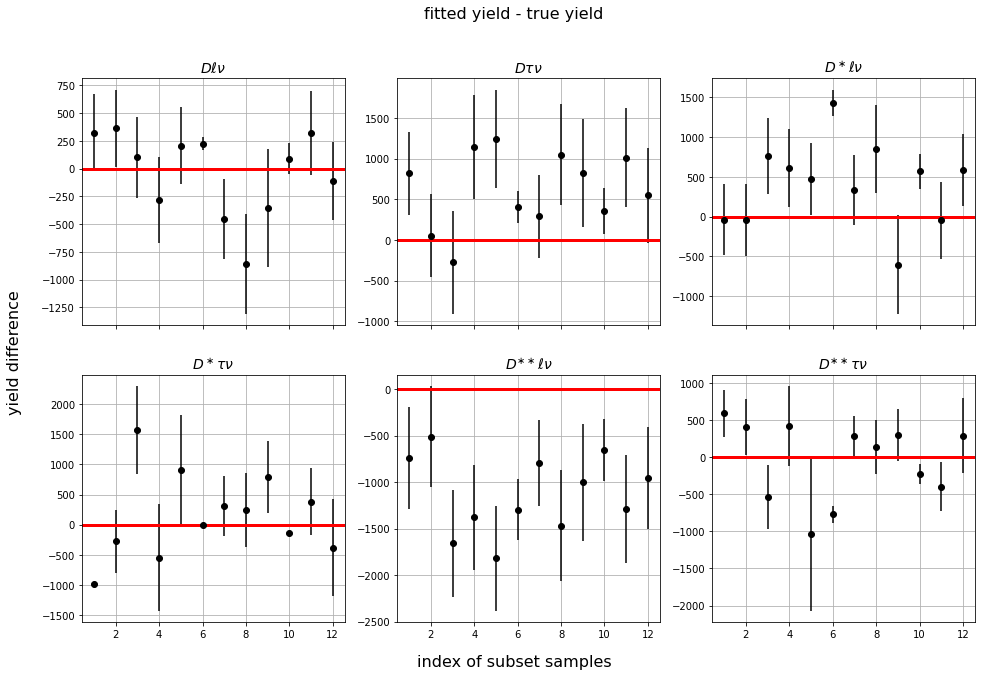

In [40]:
plot_fitting_difference('results_3.yaml')

## Define the slices of projection

In [7]:
from matplotlib import gridspec
import mplhep as hep

print(counts.shape)
p_D_l_slice = 2.5
mm2_slice = 2.4
p_D_l_slice_index, = np.asarray(np.isclose(yedges,p_D_l_slice,atol=0.1)).nonzero()
mm2_slice_index, = np.asarray(np.isclose(xedges,mm2_slice,atol=0.1)).nonzero()
print([mm2_slice_index[0], p_D_l_slice_index[0]])

(41, 47)
[17, 20]


## Plot with mplhep or plt.bar()

In [36]:
# plotting version: residual = data - all_temp
def plot_projection_residual(direction='MM2', slices=False, plot_with='mplhep'):
    if direction not in ['MM2', 'p_D_l'] or plot_with not in ['mplhep', 'pltbar']:
        raise ValueError('direction in [MM2, p_D_l] and plot_with in [mplhep, pltbar]')
    fitted_components_names = model.config.samples
    # fitted_counts = template_counts x normalization
    template_counts = [(np.array(model.nominal_rates[0][i][0])-0.0001).reshape(counts.shape) for i in range(model.config.npars)]
    fitted_templates = [template_counts[i] * fit_results.bestfit[i] for i in range(model.config.npars)]
    # fitted_counts_err = template_counts_err, normalization_err in quadrature error
    #                   = fitted_counts x sqrt( (1/template_count) + (norm_err/norm)**2 )
    #                   = fitted_counts x sqrt( (1/template_count) ) if norm ==0
    fitted_templates_err = [np.zeros_like(counts) for i in range(model.config.npars)]
    for i in range(model.config.npars):
        if fit_results.bestfit[i]==0:
            continue
        for row in range(len(template_counts[i])):
            for col in range(len(template_counts[i][row])):
                if template_counts[i][row][col]==0:
                    continue
                fitted_templates_err[i][row][col] = fitted_templates[i][row][col] * np.sqrt(1/template_counts[i][row][col] + (fit_results.uncertainty[i]/fit_results.bestfit[i])**2)
    #fitted_templates_err = [fitted_templates[i] * np.sqrt(1/template_counts[i]) if fit_results.bestfit[i]==0 else fitted_templates[i] * np.sqrt(1/template_counts[i] + (fit_results.uncertainty[i]/fit_results.bestfit[i])**2) for i in range(model.config.npars)]
    
    def extend(x):
        return np.append(x, x[-1])
    
    def errorband(bins, template_sum, template_err, ax):
        fitted_sum = np.sum(template_sum, axis=0)
        fitted_err = np.sqrt(np.sum(np.array(template_err)**2, axis=0)) # assuming the correlations between each template are 0
        ax.fill_between(bins, extend(fitted_sum - fitted_err), extend(fitted_sum + fitted_err),
        step="post", color="black", alpha=0.3, linewidth=0, zorder=100,)
        
    def plot_with_hep(bins, templates_project, templates_project_err, data, ax1, ax2):
        data_project = data.sum(axis=axis_to_be_summed_over)
        # plot the templates and data
        hep.histplot(templates_project, bin_edges, stack=True, histtype='fill', sort='yield_r', label=fitted_components_names, ax=ax1)
        # errorband(bin_edges, templates_project, templates_project_err, ax1)
        hep.histplot(data_project, bin_edges, histtype='errorbar', color='black', w2=data_project, ax=ax1)
        # plot the residual
        residual = data_project - np.sum(templates_project, axis=0)
        # Error assuming the correlations between data and templates, between each template, are 0
        residual_err = np.sqrt(data_project + np.sum(np.array(templates_project_err)**2, axis=0))
        pull = [0 if residual_err[i]==0 else (residual[i]/residual_err[i]) for i in range(len(residual))]
        #hep.histplot(residual, bin_edges, histtype='errorbar', color='black', yerr=residual_err, ax=ax2)
        hep.histplot(pull, bin_edges, histtype='errorbar', color='black', ax=ax2)
        ax2.axhline(y=0, linestyle='-', linewidth=1, color='r')
        
        ax1.grid()
        ax1.set_ylabel('# of counts per bin',fontsize=16)
        ax1.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.set_ylim(0, data_project.max()*1.2)
        ax2.set_ylabel('pull',fontsize=16)
        ax2.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1)
        
    def plot_with_bar(bins, templates_project, templates_project_err, data, ax1, ax2):        
        # calculate the arguments for plotting
        bin_width = bins[1]-bins[0]
        bin_centers = (bins[:-1] + bins[1:]) /2
        data_project = data.sum(axis=axis_to_be_summed_over)
        data_err = np.sqrt(data_project)
        
        # plot the templates
        # sort the components to plot in order of fitted templates_project size
        sorted_indices = sorted(range(model.config.npars), key=lambda i: np.sum(templates_project[i]), reverse = True)
        bottom_hist = np.zeros(data.shape[1-axis_to_be_summed_over])
        for i in sorted_indices:
            binned_counts = templates_project[i]
            ax1.bar(x=bins[:-1], height=binned_counts, bottom=bottom_hist,
                    width=bin_width, align='edge', label=f"{fitted_components_names[i]}")
            bottom_hist = bottom_hist + binned_counts
        # errorband(bin_edges, templates_project, templates_project_err, ax1)
        
        # plot the data
        ax1.errorbar(x=bin_centers, y=data_project, yerr=data_err, fmt='ko')
        # plot the residual
        residual = data_project - np.sum(templates_project, axis=0)
        # Error assuming the correlations between data and templates, between each template, are 0
        residual_err = np.sqrt(data_project + np.sum(np.array(templates_project_err)**2, axis=0))
        pull = [0 if residual_err[i]==0 else (residual[i]/residual_err[i]) for i in range(len(residual))]
        #ax2.errorbar(x=bin_centers, y=residual, yerr=residual_err, fmt='ko')
        ax2.scatter(x=bin_centers, y=pull, c='black')
        ax2.axhline(y=0, linestyle='-', linewidth=1, color='r')
        
        ax1.grid()
        ax1.set_ylabel('# of counts per bin',fontsize=16)
        ax1.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.set_ylim(0, data_project.max()*1.2)
        #ax2.set_ylabel('Residual',fontsize=16)
        ax2.set_ylabel('pull', fontsize=16)
        ax2.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1)        
    
    if direction=='MM2':
        direction_label = '$M_{miss}^2$'
        direction_unit = '$[GeV^2/c^4]$'
        other_direction_label = '$|p_D|\ +\ |p_l|$'
        other_direction_unit = '[GeV]'
        slice_position = p_D_l_slice
        axis_to_be_summed_over = 0
        bin_edges = xedges
        first_slice_index = (p_D_l_slice_index[0]-1)
        second_slice_index = (p_D_l_slice_index[0])
        
        # parameters for slices==True
        fitted_project_slice1 = [temp[:first_slice_index,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice2 = [temp[second_slice_index:,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice1_err = [temp[:first_slice_index,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        fitted_project_slice2_err = [temp[second_slice_index:,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        data_slice1 = counts[:first_slice_index,:]
        data_slice2 = counts[second_slice_index:,:]

        
    elif direction=='p_D_l':
        direction_label = '$|p_D|\ +\ |p_l|$'
        direction_unit = '[GeV]'
        other_direction_label = '$M_{miss}^2$'
        other_direction_unit = '$[GeV^2/c^4]$'
        slice_position = mm2_slice
        axis_to_be_summed_over = 1
        bin_edges = yedges
        first_slice_index = (mm2_slice_index[0]-1)
        second_slice_index = (mm2_slice_index[0])
        
        # parameters for slices==True
        fitted_project_slice1 = [temp[:,:first_slice_index].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice2 = [temp[:,second_slice_index:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice1_err = [temp[:,:first_slice_index].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        fitted_project_slice2_err = [temp[:,second_slice_index:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        data_slice1 = counts[:,:first_slice_index]
        data_slice2 = counts[:,second_slice_index:]
        
        
    else:
        raise ValueError('Current version only supports projection to either MM2 or p_D_l')
    
    if not slices:
        fig = plt.figure(figsize=(6.4,6.4))
        gs = gridspec.GridSpec(2,1, height_ratios=[0.8,0.2])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        #gs.update(hspace=0) 
        fitted_project = [temp.sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_err = [temp.sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        
        # plot the templates and data and templates_err
        if plot_with=='mplhep':
            plot_with_hep(bin_edges, fitted_project, fitted_project_err, counts, ax1, ax2)
        elif plot_with=='pltbar':
            plot_with_bar(bin_edges, fitted_project, fitted_project_err, counts, ax1, ax2)
        ax1.set_title(f'Fitting projection to {direction_label}')
        ax2.set_xlabel(direction_label)
    
    elif slices:
        fig = plt.figure(figsize=(16,7))
        spec = gridspec.GridSpec(5,2, figure=fig, wspace=0.4, hspace=0.5)
        ax1 = fig.add_subplot(spec[:-1, 0])
        ax2 = fig.add_subplot(spec[:-1, 1])
        ax3 = fig.add_subplot(spec[-1, 0])
        ax4 = fig.add_subplot(spec[-1, 1])
        #gs.update(hspace=0) 
        
        # plot the templates and data and template_err
        if plot_with=='mplhep':
            plot_with_hep(bin_edges, fitted_project_slice1, fitted_project_slice1_err, data_slice1, ax1, ax3)
            plot_with_hep(bin_edges, fitted_project_slice2, fitted_project_slice2_err, data_slice2, ax2, ax4)
        elif plot_with=='pltbar':
            plot_with_bar(bin_edges, fitted_project_slice1, fitted_project_slice1_err, data_slice1, ax1, ax3)
            plot_with_bar(bin_edges, fitted_project_slice2, fitted_project_slice2_err, data_slice2, ax2, ax4)
            
        ax1.set_title(f'{other_direction_label} < {slice_position}  {other_direction_unit}',fontsize=14)
        ax2.set_title(f'{other_direction_label} > {slice_position}  {other_direction_unit}',fontsize=14)
        fig.suptitle(f'Fitted projection to {direction_label} in slices of {other_direction_label}',fontsize=16)
        fig.supxlabel(direction_label + '  ' + direction_unit,fontsize=16)

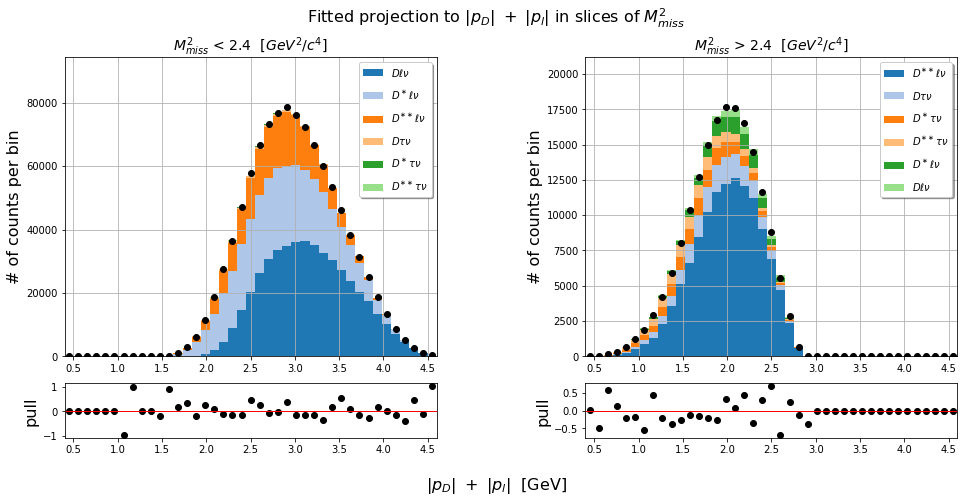

In [37]:
plot_projection_residual(direction='p_D_l',slices=True, plot_with='pltbar')

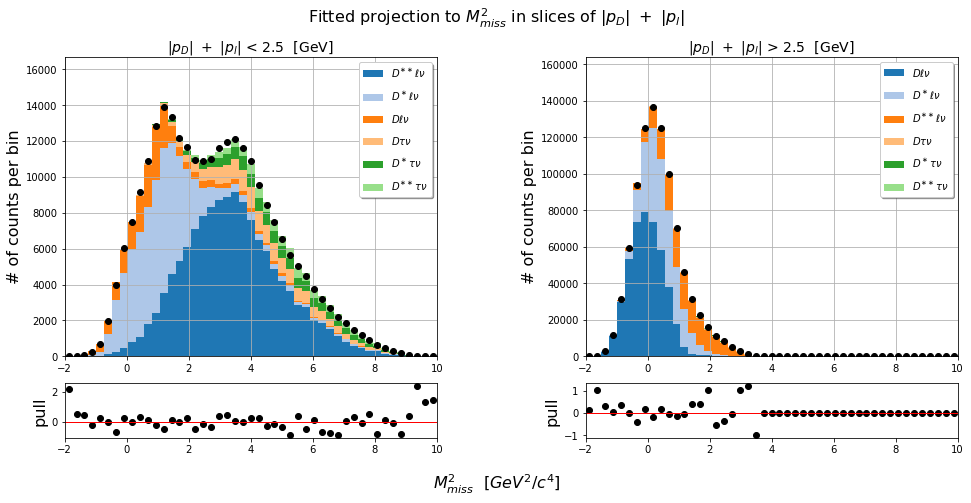

In [38]:
plot_projection_residual(direction='MM2',slices=True, plot_with='pltbar')

In [23]:
# plotting version: two residual plots, residual_signal = data - all_temp + signal1
def plot_projection_residual(direction='MM2', slices=False, plot_with='mplhep'):
    if direction not in ['MM2', 'p_D_l'] or plot_with not in ['mplhep', 'pltbar']:
        raise ValueError('direction in [MM2, p_D_l] and plot_with in [mplhep, pltbar]')
    fitted_components_names = model.config.samples
    # fitted_counts = template_counts x normalization
    template_counts = [(np.array(model.nominal_rates[0][i][0])-0.0001).reshape(counts.shape) for i in range(model.config.npars)]
    fitted_templates = [template_counts[i] * fit_results.bestfit[i] for i in range(model.config.npars)]
    # fitted_counts_err = template_counts_err, normalization_err in quadrature error
    #                   = fitted_counts x sqrt( (1/template_count) + (norm_err/norm)**2 )
    #                   = fitted_counts x sqrt( (1/template_count) ) if norm ==0
    fitted_templates_err = [np.zeros_like(counts) for i in range(model.config.npars)]
    for i in range(model.config.npars):
        if fit_results.bestfit[i]==0:
            continue
        for row in range(len(template_counts[i])):
            for col in range(len(template_counts[i][row])):
                if template_counts[i][row][col]==0:
                    continue
                fitted_templates_err[i][row][col] = fitted_templates[i][row][col] * np.sqrt(1/template_counts[i][row][col] + (fit_results.uncertainty[i]/fit_results.bestfit[i])**2)
    #fitted_templates_err = [fitted_templates[i] * np.sqrt(1/template_counts[i]) if fit_results.bestfit[i]==0 else fitted_templates[i] * np.sqrt(1/template_counts[i] + (fit_results.uncertainty[i]/fit_results.bestfit[i])**2) for i in range(model.config.npars)]
    
    def extend(x):
        return np.append(x, x[-1])
    
    def errorband(bins, template_sum, template_err, ax):
        fitted_sum = np.sum(template_sum, axis=0)
        fitted_err = np.sqrt(np.sum(np.array(template_err)**2, axis=0)) # assuming the correlations between each template are 0
        ax.fill_between(bins, extend(fitted_sum - fitted_err), extend(fitted_sum + fitted_err),
        step="post", color="black", alpha=0.3, linewidth=0, zorder=100,)   
    
    def plot_with_hep(bins, templates_project, templates_project_err, data, signal_name, ax1, ax2, ax3):
        data_project = data.sum(axis=axis_to_be_summed_over)
        # plot the templates and data
        hep.histplot(templates_project, bin_edges, stack=True, histtype='fill', sort='yield_r', label=fitted_components_names, ax=ax1)
        # errorband(bin_edges, templates_project, templates_project_err, ax1)
        hep.histplot(data_project, bin_edges, histtype='errorbar', color='black', w2=data_project, ax=ax1)
        # plot the residual
        signal_index = fitted_components_names.index(signal_name)
        residual = data_project - np.sum(templates_project, axis=0)
        residual_signal = residual + templates_project[signal_index]
        # Error assuming the correlations between data and templates, between each template, are 0
        residual_err = np.sqrt(data_project + np.sum(np.array(templates_project_err)**2, axis=0))
        residual_err_signal = np.sqrt(residual_err**2 - np.array(templates_project_err[signal_index]))
        
        pull = [0 if residual_err[i]==0 else (residual[i]/residual_err[i]) for i in range(len(residual))]
        pull_signal = [0 if residual_err_signal[i]==0 else (residual_signal[i]/residual_err_signal[i]) for i in range(len(residual_signal))]
        #hep.histplot(residual, bin_edges, histtype='errorbar', color='black', yerr=residual_err, ax=ax2)
        hep.histplot(pull, bin_edges, histtype='errorbar', color='black', ax=ax2)
        ax2.axhline(y=0, linestyle='-', linewidth=1, color='r')
        #hep.histplot(residual_signal, bin_edges, histtype='errorbar', color='black', yerr=residual_err_signal, ax=ax3)
        hep.histplot(pull_signal, bin_edges, histtype='errorbar', color='black', ax=ax3)
        ax3.axhline(y=0, linestyle='-', linewidth=1, color='r')
        
        ax1.grid()
        ax1.set_ylabel('# of counts per bin',fontsize=16)
        ax1.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.set_ylim(0, data_project.max()*1.2)
        ax2.set_ylabel('pull',fontsize=14)
        ax2.set_xlim(bin_edges.min(), bin_edges.max())
        ax3.set_ylabel('pull + signal',fontsize=10)
        ax3.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1)
        
    def plot_with_bar(bins, templates_project, templates_project_err, data, signal_name, ax1, ax2, ax3):        
        # calculate the arguments for plotting
        bin_width = bins[1]-bins[0]
        bin_centers = (bins[:-1] + bins[1:]) /2
        data_project = data.sum(axis=axis_to_be_summed_over)
        data_err = np.sqrt(data_project)
        
        # plot the templates
        # sort the components to plot in order of fitted templates_project size
        sorted_indices = sorted(range(model.config.npars), key=lambda i: np.sum(templates_project[i]), reverse = True)
        bottom_hist = np.zeros(data.shape[1-axis_to_be_summed_over])
        for i in sorted_indices:
            binned_counts = templates_project[i]
            ax1.bar(x=bins[:-1], height=binned_counts, bottom=bottom_hist,
                    width=bin_width, align='edge', label=f"{fitted_components_names[i]}")
            bottom_hist = bottom_hist + binned_counts
        # errorband(bin_edges, templates_project, templates_project_err, ax1)
        
        # plot the data
        ax1.errorbar(x=bin_centers, y=data_project, yerr=data_err, fmt='ko')
        # plot the residual
        signal_index = fitted_components_names.index(signal_name)
        residual = data_project - np.sum(templates_project, axis=0)
        residual_signal = residual + templates_project[signal_index]
        # Error assuming the correlations between data and templates, between each template, are 0
        residual_err = np.sqrt(data_project + np.sum(np.array(templates_project_err)**2, axis=0))
        residual_err_signal = np.sqrt(residual_err**2 - np.array(templates_project_err[signal_index]))
        
        pull = [0 if residual_err[i]==0 else (residual[i]/residual_err[i]) for i in range(len(residual))]
        pull_signal = [0 if residual_err_signal[i]==0 else (residual_signal[i]/residual_err_signal[i]) for i in range(len(residual_signal))]
        ax2.scatter(x=bin_centers, y=pull, c='black')
        ax2.axhline(y=0, linestyle='-', linewidth=1, color='r')
        ax3.scatter(x=bin_centers, y=pull_signal, c='black')
        ax3.axhline(y=0, linestyle='-', linewidth=1, color='r')
                
        ax1.grid()
        ax1.set_ylabel('# of counts per bin',fontsize=16)
        ax1.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.set_ylim(0, data_project.max()*1.2)
        ax2.set_ylabel('pull',fontsize=14)
        ax2.set_xlim(bin_edges.min(), bin_edges.max())
        ax3.set_ylabel('pull + signal',fontsize=10)
        ax3.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1)       
    
    if direction=='MM2':
        direction_label = '$M_{miss}^2$'
        direction_unit = '$[GeV^2/c^4]$'
        other_direction_label = '$|p_D|\ +\ |p_l|$'
        other_direction_unit = '[GeV]'
        slice1_signal = '$D\\tau\\nu$'
        slice2_signal = '$D\\ell\\nu$'
        slice_position = p_D_l_slice
        axis_to_be_summed_over = 0
        bin_edges = xedges
        first_slice_index = (p_D_l_slice_index[0]-1)
        second_slice_index = (p_D_l_slice_index[0])
        
        # parameters for slices==True
        fitted_project_slice1 = [temp[:first_slice_index,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice2 = [temp[second_slice_index:,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice1_err = [temp[:first_slice_index,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        fitted_project_slice2_err = [temp[second_slice_index:,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        data_slice1 = counts[:first_slice_index,:]
        data_slice2 = counts[second_slice_index:,:]
        
    elif direction=='p_D_l':
        direction_label = '$|p_D|\ +\ |p_l|$'
        direction_unit = '[GeV]'
        other_direction_label = '$M_{miss}^2$'
        other_direction_unit = '$[GeV^2/c^4]$'
        slice1_signal = '$D\\ell\\nu$'
        slice2_signal = '$D\\tau\\nu$'
        slice_position = mm2_slice
        axis_to_be_summed_over = 1
        bin_edges = yedges
        first_slice_index = (mm2_slice_index[0]-1)
        second_slice_index = (mm2_slice_index[0])
        
        # parameters for slices==True
        fitted_project_slice1 = [temp[:,:first_slice_index].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice2 = [temp[:,second_slice_index:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice1_err = [temp[:,:first_slice_index].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        fitted_project_slice2_err = [temp[:,second_slice_index:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        data_slice1 = counts[:,:first_slice_index]
        data_slice2 = counts[:,second_slice_index:]

        
    else:
        raise ValueError('Current version only supports projection to either MM2 or p_D_l')


    if not slices:
        fig = plt.figure(figsize=(6.4,6.4))
        gs = gridspec.GridSpec(3,1, height_ratios=[0.7,0.15,0.15])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        ax3 = fig.add_subplot(gs[2])
        gs.update(hspace=0.3) 
        fitted_project = [temp.sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_err = [temp.sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        
        # plot the templates and data and templates_err
        if plot_with=='mplhep':
            plot_with_hep(bin_edges, fitted_project, fitted_project_err, counts, '$D\\tau\\nu$', ax1, ax2,ax3)
        elif plot_with=='pltbar':
            plot_with_bar(bin_edges, fitted_project, fitted_project_err, counts, '$D\\tau\\nu$', ax1, ax2,ax3)
        ax1.set_title(f'Fitting projection to {direction_label}')
        ax3.set_xlabel(direction_label)
    
    elif slices:
        fig = plt.figure(figsize=(16,7))
        spec = gridspec.GridSpec(6,2, figure=fig, wspace=0.4, hspace=0.5)
        ax1 = fig.add_subplot(spec[:-2, 0])
        ax2 = fig.add_subplot(spec[:-2, 1])
        ax3 = fig.add_subplot(spec[-2, 0])
        ax4 = fig.add_subplot(spec[-2, 1])
        ax5 = fig.add_subplot(spec[-1, 0])
        ax6 = fig.add_subplot(spec[-1, 1])
        #gs.update(hspace=0) 
        
        # plot the templates and data and template_err
        if plot_with=='mplhep':
            plot_with_hep(bin_edges, fitted_project_slice1, fitted_project_slice1_err, data_slice1, slice1_signal, ax1, ax3, ax5)
            plot_with_hep(bin_edges, fitted_project_slice2, fitted_project_slice2_err, data_slice2, slice2_signal, ax2, ax4, ax6)
        elif plot_with=='pltbar':
            plot_with_bar(bin_edges, fitted_project_slice1, fitted_project_slice1_err, data_slice1, slice1_signal, ax1, ax3, ax5)
            plot_with_bar(bin_edges, fitted_project_slice2, fitted_project_slice2_err, data_slice2, slice2_signal, ax2, ax4, ax6)
            
        ax1.set_title(f'{other_direction_label} < {slice_position}  {other_direction_unit}')
        ax2.set_title(f'{other_direction_label} > {slice_position}  {other_direction_unit}')
        fig.suptitle(f'Fitted projection to {direction_label} in slices of {other_direction_label}')
        fig.supxlabel(direction_label + '  ' + direction_unit)

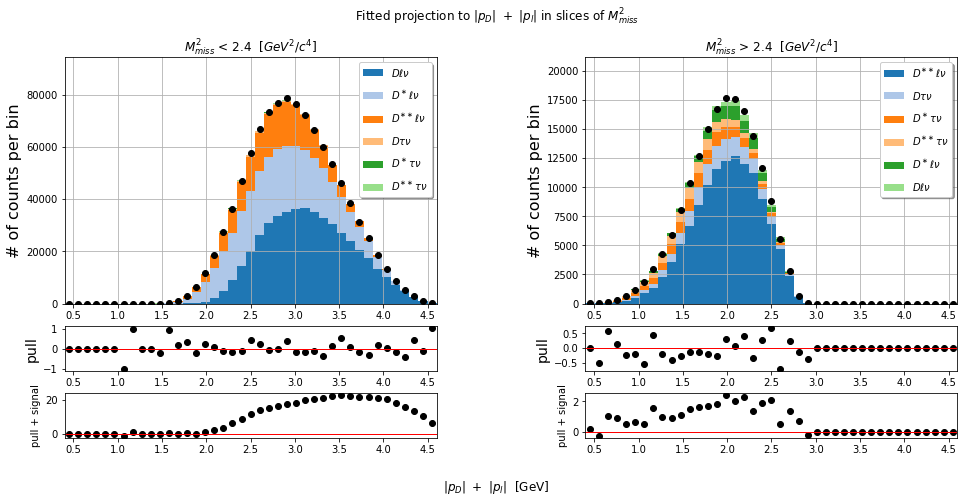

In [24]:
plot_projection_residual(direction='p_D_l',slices=True, plot_with='pltbar')

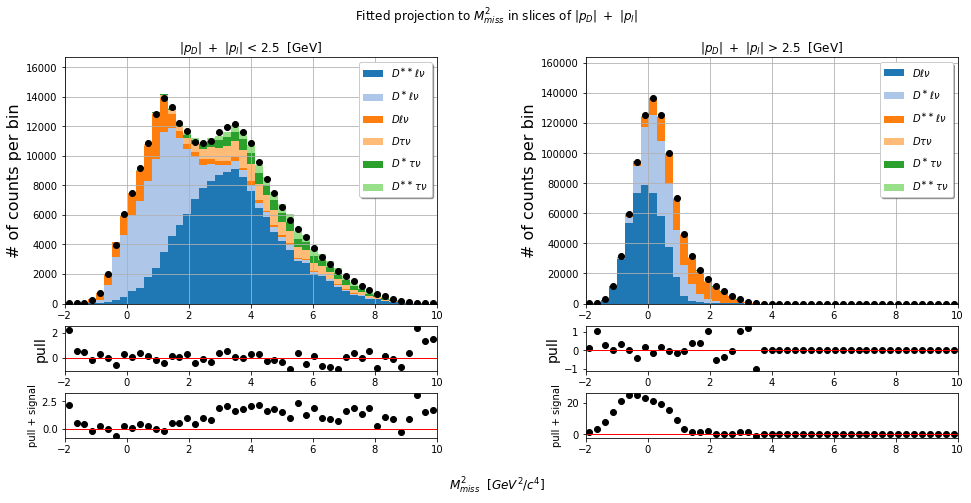

In [25]:
plot_projection_residual(direction='MM2',slices=True, plot_with='pltbar')

In [ ]:
# plotting version: residual_signals = data - all_temp + signal1 + signal2
def plot_projection_residual(direction='MM2', slices=False, plot_with='mplhep'):
    fitted_templates = [np.array(model_1.spec['channels'][0]['samples'][i]['data']).reshape(counts.shape) * parameters[i,0] for i in range(model.config.npars)]
    fitted_templates_err = [np.array(model_1.spec['channels'][0]['samples'][i]['data']).reshape(counts.shape) * parameters[i,1] for i in range(model.config.npars)]
    fitted_components_names = [model_1.spec['channels'][0]['samples'][i]['name'] for i in range(model.config.npars)]
    
    def extend(x):
        return np.append(x, x[-1])
    
    def errorband(bins, template_sum, template_err, ax):
        fitted_sum = np.sum(template_sum, axis=0)
        fitted_err = np.sqrt(np.sum(np.array(template_err)**2, axis=0)) # assuming the correlations between each template are 0
        ax.fill_between(bins, extend(fitted_sum - fitted_err), extend(fitted_sum + fitted_err),
        step="post", color="black", alpha=0.3, linewidth=0, zorder=100,)
        
    def plot_with_hep(bins, templates_project, templates_project_err, data, signal_names, ax1, ax2):
        data_project = data.sum(axis=axis_to_be_summed_over)
        # plot the templates and data
        hep.histplot(templates_project, bin_edges, stack=True, histtype='fill', sort='yield_r', label=fitted_components_names, ax=ax1)
        # errorband(bin_edges, templates_project, templates_project_err, ax1)
        hep.histplot(data_project, bin_edges, histtype='errorbar', color='black', w2=data_project, ax=ax1)
        # plot the residual
        signal_index1 = fitted_components_names.index(signal_names[0])
        signal_index2 = fitted_components_names.index(signal_names[1])
        residual = data_project - np.sum(templates_project, axis=0)
        residual_signals = residual + templates_project[signal_index1] + templates_project[signal_index2]
        # Error assuming the correlations between data and templates, between each template, are 0
        residual_err = np.sqrt(data_project + np.sum(np.array(templates_project_err)**2, axis=0))
        residual_err_signals = np.sqrt(residual_err**2 - np.array(templates_project_err[signal_index1]) - np.array(templates_project_err[signal_index2]))
        hep.histplot(residual_signals, bin_edges, histtype='errorbar', color='black', yerr=residual_err_signals, ax=ax2)
        ax2.axhline(y=0, linestyle='-', linewidth=1, color='r')
        
        ax1.grid()
        ax1.set_ylabel('# of counts per bin',fontsize=16)
        ax1.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.set_ylim(0, data_project.max()*1.2)
        ax2.set_ylabel('Data-Bkg',fontsize=16)
        ax2.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1)
        
    def plot_with_bar(bins, templates_project, templates_project_err, data, signal_names, ax1, ax2):        
        # calculate the arguments for plotting
        bin_width = bins[1]-bins[0]
        bin_centers = (bins[:-1] + bins[1:]) /2
        data_project = data.sum(axis=axis_to_be_summed_over)
        data_err = np.sqrt(data_project)
        
        # plot the templates
        # sort the components to plot in order of fitted templates_project size
        sorted_indices = sorted(range(model.config.npars), key=lambda i: np.sum(templates_project[i]), reverse = True)
        bottom_hist = np.zeros(data.shape[1-axis_to_be_summed_over])
        for i in sorted_indices:
            binned_counts = templates_project[i]
            ax1.bar(x=bins[:-1], height=binned_counts, bottom=bottom_hist,
                    width=bin_width, align='edge', label=f"{fitted_components_names[i]}")
            bottom_hist = bottom_hist + binned_counts
        # errorband(bin_edges, templates_project, templates_project_err, ax1)
        
        # plot the data
        ax1.errorbar(x=bin_centers, y=data_project, yerr=data_err, fmt='ko')
        # plot the residual
        signal_index1 = fitted_components_names.index(signal_names[0])
        signal_index2 = fitted_components_names.index(signal_names[1])
        residual = data_project - np.sum(templates_project, axis=0)
        residual_signals = residual + templates_project[signal_index1] + templates_project[signal_index2]
        # Error assuming the correlations between data and templates, between each template, are 0
        residual_err = np.sqrt(data_project + np.sum(np.array(templates_project_err)**2, axis=0))
        residual_err_signals = np.sqrt(residual_err**2 - np.array(templates_project_err[signal_index1]) - np.array(templates_project_err[signal_index2]))
        ax2.errorbar(x=bin_centers, y=residual_signals, yerr=residual_err_signals, fmt='ko')
        ax2.axhline(y=0, linestyle='-', linewidth=1, color='r')
        
        ax1.grid()
        ax1.set_ylabel('# of counts per bin',fontsize=16)
        ax1.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.set_ylim(0, data_project.max()*1.2)
        ax2.set_ylabel('Data-Bkg',fontsize=16)
        ax2.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1)
    
    if direction=='MM2':
        direction_label = '$M_{miss}^2$'
        direction_unit = '$[GeV^2/c^4]$'
        other_direction_label = '$|p_D|\ +\ |p_l|$'
        other_direction_unit = '[GeV]'
        slice1_signals = ['D_tau_nu', 'Dst_tau_nu']
        slice2_signals = ['D_l_nu', 'Dst_l_nu']
        slice_position = p_D_l_slice
        axis_to_be_summed_over = 0
        bin_edges = xedges
        first_slice_index = (p_D_l_slice_index[0]-1)
        second_slice_index = (p_D_l_slice_index[0])
        
        # parameters for slices==True
        fitted_project_slice1 = [temp[:first_slice_index,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice2 = [temp[second_slice_index:,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice1_err = [temp[:first_slice_index,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        fitted_project_slice2_err = [temp[second_slice_index:,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        data_slice1 = counts[:first_slice_index,:]
        data_slice2 = counts[second_slice_index:,:]
        
    elif direction=='p_D_l':
        direction_label = '$|p_D|\ +\ |p_l|$'
        direction_unit = '[GeV]'
        other_direction_label = '$M_{miss}^2$'
        other_direction_unit = '$[GeV^2/c^4]$'
        slice1_signals = ['D_l_nu', 'Dst_l_nu']
        slice2_signals = ['D_tau_nu', 'Dst_tau_nu']
        slice_position = mm2_slice
        axis_to_be_summed_over = 1
        bin_edges = yedges
        first_slice_index = (mm2_slice_index[0]-1)
        second_slice_index = (mm2_slice_index[0])
        
        # parameters for slices==True
        fitted_project_slice1 = [temp[:,:first_slice_index].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice2 = [temp[:,second_slice_index:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice1_err = [temp[:,:first_slice_index].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        fitted_project_slice2_err = [temp[:,second_slice_index:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        data_slice1 = counts[:,:first_slice_index]
        data_slice2 = counts[:,second_slice_index:]
        
        
    else:
        raise ValueError('Current version only supports projection to either MM2 or p_D_l')
    
    if not slices:
        fig = plt.figure(figsize=(6.4,6.4))
        gs = gridspec.GridSpec(3,1, height_ratios=[0.8,0.2])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        #gs.update(hspace=0.3) 
        fitted_project = [temp.sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_err = [temp.sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        
        # plot the templates and data and templates_err
        if plot_with=='mplhep':
            plot_with_hep(bin_edges, fitted_project, fitted_project_err, counts, 'D_tau_nu', ax1, ax2)
        elif plot_with=='pltbar':
            plot_with_bar(bin_edges, fitted_project, fitted_project_err, counts, 'D_tau_nu', ax1, ax2)
        ax1.set_title(f'Fitting projection to {direction_label}')
        ax2.set_xlabel(direction_label)
    
    elif slices:
        fig = plt.figure(figsize=(16,7))
        spec = gridspec.GridSpec(5,2, figure=fig, wspace=1, hspace=0.5)
        ax1 = fig.add_subplot(spec[:-1, 0])
        ax2 = fig.add_subplot(spec[:-1, 1])
        ax3 = fig.add_subplot(spec[-1, 0])
        ax4 = fig.add_subplot(spec[-1, 1])
        #gs.update(hspace=0) 
        
        # plot the templates and data and template_err
        if plot_with=='mplhep':
            plot_with_hep(bin_edges, fitted_project_slice1, fitted_project_slice1_err, data_slice1, slice1_signals, ax1, ax3)
            plot_with_hep(bin_edges, fitted_project_slice2, fitted_project_slice2_err, data_slice2, slice2_signals, ax2, ax4)
        elif plot_with=='pltbar':
            plot_with_bar(bin_edges, fitted_project_slice1, fitted_project_slice1_err, data_slice1, slice1_signals, ax1, ax3)
            plot_with_bar(bin_edges, fitted_project_slice2, fitted_project_slice2_err, data_slice2, slice2_signals, ax2, ax4)
            
        ax1.set_title(f'{other_direction_label} < {slice_position}  {other_direction_unit}')
        ax2.set_title(f'{other_direction_label} > {slice_position}  {other_direction_unit}')
        fig.suptitle(f'Fitted projection to {direction_label} in slices of {other_direction_label}')
        fig.supxlabel(direction_label + '  ' + direction_unit)

# 4. Get fitting templates

In [ ]:
# apply BDTs
# plot mm2, mm2 vs p_D_l
# save the templates

In [8]:
import basf2_mva
import pandas

identifier_1 = '/home/belle/zhangboy/R_D/Generic_MC14rd/Continuum_Suppression/MVA1_FastBDT.xml'
test_1 = '../Ntuples/MC_eidglobal_10k_cut.root'
output_file_1 = '../Ntuples/MC_eidglobal_10k_MVA1.root'

identifier_1_5 = '/home/belle/zhangboy/R_D/Generic_MC14rd/B_bkg_Suppression/MVA1_5/MVA1_5_FastBDT.xml'
test_1_5 = '../Ntuples/MC_eidglobal_10k_cut.root'
output_file_1_5 = '../Ntuples/MC_eidglobal_10k_MVA1_5.root'

output_file_1_5_applied = '../Ntuples/MC_eidglobal_10k_MVA1_5_applied.root'

identifier_2_1 = '/home/belle/zhangboy/R_D/Generic_MC14rd/B_bkg_Suppression/MVA2/MVA2_1_FastBDT.xml'
test_2_1 = output_file_1_5_applied
output_file_2_1 = '../Ntuples/MC_eidglobal_10k_MVA2_1.root'
output_file_2_1_applied = '../Ntuples/MC_eidglobal_10k_MVA2_1_applied.root'

In [9]:
# apply CS BDT identifier_1, merge data file and mva output, rename the column
basf2_mva.expert(basf2_mva.vector(identifier_1),  # weightfile
                 basf2_mva.vector(test_1),
                 'B0', output_file_1)

df1 = df_cut.drop_duplicates(subset=['__experiment__','__run__','__event__','__production__','__candidate__']).reset_index(drop=True)
df2 = root_pandas.read_root(output_file_1)
print(len(df1)==len(df2))
df_1 = pandas.concat([df1,df2],axis=1)

df_1=df_1.rename(columns={"__slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slContinuum_Suppression__slMVA1_FastBDT__ptxml": "MVA1_output"})
df_1=df_1.drop(columns=['__slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slContinuum_Suppression__slMVA1_FastBDT__ptxml_isSignal'])

# apply BDT 1_5 identifier_1_5, merge, rename, change the output type, save
basf2_mva.expert(basf2_mva.vector(identifier_1_5),  # weightfile
                 basf2_mva.vector(test_1_5),
                 'B0', output_file_1_5)

df3 = root_pandas.read_root(output_file_1_5)
print(len(df_1)==len(df3))
df_1_5 = pandas.concat([df_1,df3],axis=1)

df_1_5=df_1_5.rename(columns={"__slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slB_bkg_Suppression__slMVA1_5__slMVA1_5_FastBDT__ptxml": "MVA1_5_output"})
df_1_5=df_1_5.drop(columns=['__slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slB_bkg_Suppression__slMVA1_5__slMVA1_5_FastBDT__ptxml_isSignal'])

df_1_5.MVA1_5_output=np.float64(df_1_5.MVA1_5_output)
print(type(df_1_5.MVA1_5_output[0]))
print(type(df_1_5.isSignal[0]))

df_1_5.to_root(output_file_1_5_applied, key='B0')

# apply BDT 2_1 identifier_2_1, merge, rename, save
basf2_mva.expert(basf2_mva.vector(identifier_2_1),  # weightfile
                 basf2_mva.vector(test_2_1),
                 'B0', output_file_2_1)

df4 = root_pandas.read_root(output_file_2_1)
print(len(df_1_5)==len(df4))
df_2_1 = pandas.concat([df_1_5, df4],axis=1)
print(len(df_1_5)==len(df_2_1))

df_2_1=df_2_1.rename(columns={"__slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slB_bkg_Suppression__slMVA2__slMVA2_1_FastBDT__ptxml": "MVA2_1_output"})
df_2_1=df_2_1.drop(columns=['__slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slB_bkg_Suppression__slMVA2__slMVA2_1_FastBDT__ptxml_isSignal'])

df_2_1.to_root(output_file_2_1_applied, key='B0')

[INFO] Elapsed application time in ms 19.8755 for MVA1_FastBDT.xml
[WARNING] String passed to makeROOTCompatible contains double-underscore __, which is used internally for escaping special characters. It is recommended to avoid this. However escaping a string twice with makeROOTCompatible is safe, but will print this warning. Passed string: __slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slContinuum_Suppression__slMVA1_FastBDT__ptxml_isSignal
False
[INFO] Elapsed application time in ms 17.8737 for MVA1_5_FastBDT.xml
[WARNING] String passed to makeROOTCompatible contains double-underscore __, which is used internally for escaping special characters. It is recommended to avoid this. However escaping a string twice with makeROOTCompatible is safe, but will print this warning. Passed string: __slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slB_bkg_Suppression__slMVA1_5__slMVA1_5_FastBDT__ptxml_isSignal
True
<class 'numpy.float64'>
<class 'numpy.float64'>


/cvmfs/belle.cern.ch/el7/externals/v01-10-02/Linux_x86_64/common/lib/python3.8/site-packages/root_numpy/_tree.py:575: UserWarning: converter for dtype('O') is not implemented (skipping)
  cobj = _librootnumpy.array2tree_toCObj(arr, name=name, tree=incobj)


[INFO] Elapsed application time in ms 16.9586 for MVA2_1_FastBDT.xml
[WARNING] String passed to makeROOTCompatible contains double-underscore __, which is used internally for escaping special characters. It is recommended to avoid this. However escaping a string twice with makeROOTCompatible is safe, but will print this warning. Passed string: __slhome__slbelle__slzhangboy__slR_D__slGeneric_MC14rd__slB_bkg_Suppression__slMVA2__slMVA2_1_FastBDT__ptxml_isSignal
True
True


In [10]:
df_2_1.columns
len(df_2_1)

1589